In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, ConcatDataset

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Step 1: Load ResNet-50 model pre-trained on ImageNet
teacher_model = models.resnet50(weights='ResNet50_Weights.DEFAULT')

# Add global average pooling after the last convolutional block (layer4)
teacher_model.avgpool = nn.AdaptiveAvgPool2d(1)  # Add global average pooling layer to reduce the feature map to 1x1

# Now the model will have global average pooling followed by the fully connected layers
teacher_model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(2048, 4),
)
teacher_model.to(device)
# Step 5: Print the modified model architecture to verify changes
print(teacher_model)

In [ ]:
#To load the saved weights into the model architecture:
teacher_model.load_state_dict(torch.load("ResNet50_best.pth")) 

In [ ]:
teacher_model.to(device)

In [6]:
teacher_model.eval()  # Set to evaluation mode
for param in teacher_model.parameters():
    param.requires_grad = False  # Freeze all weights

In [ ]:
# Load DeiT Pre-trained Model
student_model = torch.hub.load('facebookresearch/deit:main',
                           'deit_base_distilled_patch16_224', pretrained=True)

In [ ]:
num_classes = 4  # Set your number of classes

# Replace classification head
student_model.head = nn.Linear(student_model.head.in_features, num_classes)

# Replace distillation head
student_model.head_dist = nn.Linear(student_model.head_dist.in_features, num_classes)
student_model.to(device)

In [ ]:
#To load the saved weights into the model architecture:
student_model.load_state_dict(torch.load("Deit_faceRes_base_distilled.pth")) 

In [ ]:
# Freeze Layers 1 to 10
for layer_idx, layer in enumerate(student_model.blocks):
    if layer_idx < 10:  # Freeze layers 1 to 11 (index 0 to 10)
        for param in layer.parameters():
            param.requires_grad = False
    else:
        # Ensure layer 11, 12 remains trainable
        for param in layer.parameters():
            param.requires_grad = True

# Confirm that only layer 12's parameters are trainable
for name, param in student_model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

# Update Optimizer: Only trainable parameters
criterion = torch.nn.CrossEntropyLoss()
T = 4.0  # Temperature for soft labels
alpha = 0.5  # Weight for hard vs. soft labels

# Optimizer
optimizer = optim.AdamW(student_model.parameters(), lr=1e-4, weight_decay=0.01)
student_model.to(device)

In [7]:
# Define image transformations (preprocessing for CNN)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize for pretrained models
])

In [8]:
horizontal_flip_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.RandomHorizontalFlip(p=1.0), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
vertical_flip_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.RandomVerticalFlip(p=1.0), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
random_rotatation_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.RandomRotation(degrees=25), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [9]:
# Set up dataset and dataloaders
# Assuming images are organized in folders: 'root_folder/class1/', 'root_folder/class2/', etc.
data_dir = './maps_git/'  # Path to your image folder
train_data_1 = datasets.ImageFolder(root=data_dir, transform=horizontal_flip_transform)
train_data_2 = datasets.ImageFolder(root=data_dir, transform=vertical_flip_transform)
train_data_3 = datasets.ImageFolder(root=data_dir, transform=random_rotatation_transform)
train_data_4 = datasets.ImageFolder(root=data_dir, transform=transform)
augmented_dataset = ConcatDataset([train_data_1, train_data_2, train_data_3, train_data_4])
train_size = int(0.7 * len(augmented_dataset))
val_size = int(0.2 * len(augmented_dataset))
test_size = len(augmented_dataset) - (train_size + val_size)
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(augmented_dataset, [train_size, val_size, test_size], generator=generator1)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
%%time

best_val_loss = float('inf')
patience = 5
counter = 0

# Track performance for this fold
fold_train_loss = []
fold_train_accuracy = []
fold_val_loss = []
fold_val_accuracy = []

num_epochs = 25
for epoch in range(num_epochs):
    # ----------------------------
    # TRAINING PHASE
    # ----------------------------
    student_model.train()
    teacher_model.eval()
    total_train_loss = 0.0
    correct_train, total_train = 0, 0

    criterion_cls = nn.CrossEntropyLoss()  # Hard labels
    criterion_dist = nn.KLDivLoss(reduction='batchmean')  # Soft labels

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass (student)
        cls_logits, dist_logits = student_model(images)

        # Compute hard label loss
        loss_cls = criterion_cls(cls_logits, labels)

        # Get soft labels from teacher model (no gradients)
        with torch.no_grad():
            teacher_logits = teacher_model(images)

        # Softmax with temperature for distillation
        soft_teacher = F.softmax(teacher_logits / T, dim=-1)
        soft_student = F.log_softmax(dist_logits / T, dim=-1)
    
        # Distillation loss (KL divergence)
        loss_dist = criterion_dist(soft_student, soft_teacher) * (T ** 2)  # Scale by T^2
    

        # Total loss (combining hard labels and soft labels)
        loss = (1 - alpha) * loss_cls +  alpha * loss_dist

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        # Compute training accuracy
        predictions = torch.argmax(cls_logits, dim=1)
        total_train += labels.size(0)
        correct_train += (predictions == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    fold_train_loss.append(avg_train_loss)
    fold_train_accuracy.append(train_accuracy)
    
    # ----------------------------
    # VALIDATION PHASE
    # ----------------------------
    student_model.eval()
    total_val_loss = 0.0
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:  # Use validation set
            images, labels = images.to(device), labels.to(device)

            # Forward pass (student)
            outputs = student_model(images)

            # Handle output format (DeiT returns tuple during training, but may not in eval)
            if isinstance(outputs, tuple):
                cls_logits = outputs[0]  # Discard dist_logits during validation
            else:
                cls_logits = outputs

            # Compute hard label loss
            loss = criterion_cls(cls_logits, labels)

            total_val_loss += loss.item()

            # Compute validation accuracy
            predictions = torch.argmax(cls_logits, dim=1)
            total_val += labels.size(0)
            correct_val += (predictions == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    fold_val_loss.append(avg_val_loss)
    fold_val_accuracy.append(val_accuracy)
    # ----------------------------
    # PRINT EPOCH METRICS
    # ----------------------------
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
    print(f"  Val   Loss: {avg_val_loss:.4f}, Val   Acc: {val_accuracy:.2f}%\n")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(student_model.state_dict(), "Deit_student_resnet50.pth")
        print('The best model was saved.')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Plot Training and Validation Loss/Accuracy
epochs = range(1, 8 + 1)

plt.figure(figsize=(12, 6))
# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, fold_train_loss, label="Training Loss", marker="o")
plt.plot(epochs, fold_val_loss, label="Validation Loss", marker="o")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, fold_train_accuracy, label="Training Accuracy", marker="o")
plt.plot(epochs, fold_val_accuracy, label="Validation Accuracy", marker="o")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

print("Fine-tuning complete!")

In [5]:
#To load the saved weights into the model architecture:
student_model.load_state_dict(torch.load("DeiT_student_resnet50.pth")) 

/tmp/ipykernel_8695/1475264189.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student_model.load_state_dict(torch.load("DeiT_student_12_idotdo_resnet50.pth"))


<All keys matched successfully>

In [ ]:
# Evaluate on test set
student_model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        logits = student_model(images)

        # Average both outputs for final prediction
        predictions = torch.argmax(logits, dim=1)

        total += labels.size(0)
        correct += (predictions == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


In [12]:
def test_model(model, loader):
    model.eval()
    acc = 0.
    y_test, y_prediction =[], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            pred = logits.argmax(dim=1)
            acc += (pred == labels).sum().item()
            y_test.extend(labels.cpu().numpy())
            y_prediction.extend(pred.cpu().numpy())
    size = len(loader.dataset)
    acc = 100 * acc / size
    print(f'Test accuracy on {size} test samples is {acc:.2f}%')
    return y_test, y_prediction

In [13]:
class_names = {0: 'AA', 1: 'AI', 2: 'IA', 3: 'II'}
kept_classes = [0, 1, 2, 3]

In [14]:
def plot_confusion_matrix(y_true, y_pred, class_names, kept_classes):
    dim = len(kept_classes)
    labels = [class_names[i] for i in kept_classes]
    # Plot the confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    norm_conf_mat = conf_mat / np.sum(conf_mat, axis=1)
    # plot the matrix
    fig, ax = plt.subplots()
    plt.imshow(norm_conf_mat)
    plt.title('Confusion Matrix')
    plt.xlabel('Predictions')
    plt.ylabel('Labels')
    plt.xticks(range(dim), labels, rotation=45)
    plt.yticks(range(dim), labels)
    plt.colorbar()
    # Put number of each cell in plot
    for i in range(dim):
        for j in range(dim):
            c = conf_mat[j, i]
            color = 'black' if c > 500 else 'white'
            ax.text(i, j, str(int(c)), va='center', ha='center', color=color)
    plt.show()

Test accuracy on 350 test samples is 84.00%


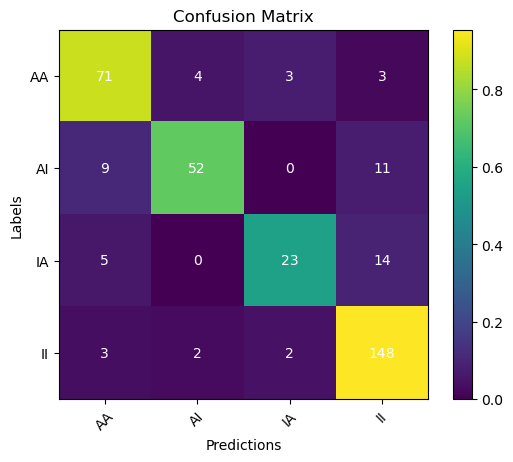

In [18]:
# Test the model
y_test, y_pred = test_model(student_model, test_loader)

# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names, kept_classes)

In [19]:
print(classification_report(y_test, y_pred, target_names= class_names.values()))

              precision    recall  f1-score   support

          AA       0.81      0.88      0.84        81
          AI       0.90      0.72      0.80        72
          IA       0.82      0.55      0.66        42
          II       0.84      0.95      0.89       155

    accuracy                           0.84       350
   macro avg       0.84      0.78      0.80       350
weighted avg       0.84      0.84      0.83       350



In [20]:
from PIL import Image
import matplotlib.cm as cm
import cv2
import torch.nn as nn

/home/linu/anaconda3/envs/machlearn1/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


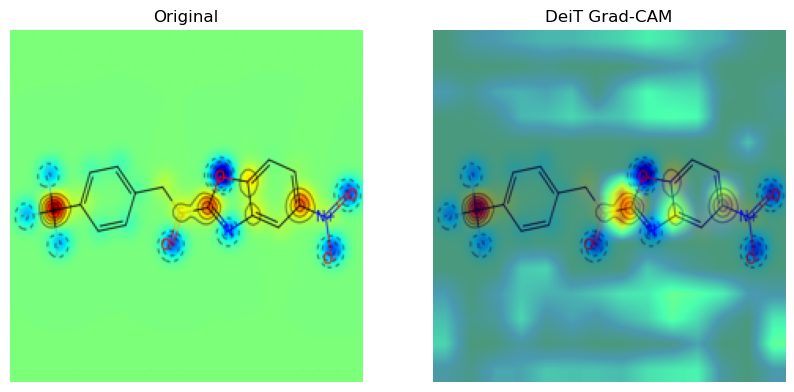

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

model = student_model
model.eval().to('cpu')

# 2. Define Grad-CAM for DeiT
class DeiT_GradCAM:
    def __init__(self, model):
        self.model = model
        self.activations = None
        self.gradients = None
        
        # Register hooks on the last attention block
        target_layer = model.blocks[-1].attn.qkv
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)
    
    def save_activations(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def get_cam(self, x, target_class=None):
        # Forward pass
        outputs = self.model(x)
        
        # DeiT returns (cls_token_output, dist_token_output)
        cls_output = outputs[0] if isinstance(outputs, tuple) else outputs
        
        if target_class is None:
            target_class = torch.argmax(cls_output).item()
        
        # Backward pass
        self.model.zero_grad()
        one_hot = torch.zeros_like(cls_output)
        if len(one_hot.shape) == 1:
            one_hot[target_class] = 1
        else:
            one_hot[0, target_class] = 1
        cls_output.backward(gradient=one_hot, retain_graph=True)
        
        # Process gradients and activations
        B, N, C = self.gradients.shape
        grad = self.gradients.view(B, N, 3, C//3).mean(dim=2)  # Average across QKV
        act = self.activations.view(B, N, 3, C//3).mean(dim=2)
        
        # Grad-CAM computation
        weights = grad.mean(dim=1, keepdim=True)
        cam = torch.matmul(act, weights.permute(0,2,1))
        cam = F.relu(cam.squeeze(-1))
        cam = cam - cam.min()
        cam = cam / cam.max()
        return cam.squeeze().cpu().numpy()

# 3. Image Preprocessing
def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(img_path).convert('RGB')
    return transform(img).unsqueeze(0), img

# 4. Visualization
def visualize_gradcam(img_path, target_class=None):
    # Preprocess
    input_tensor, orig_img = preprocess_image(img_path)
    
    # Initialize Grad-CAM
    gradcam = DeiT_GradCAM(model)
    
    # Generate CAM
    cam = gradcam.get_cam(input_tensor, target_class)
    
    # Handle different CAM lengths
    if len(cam) == 198:  # 196 patches + 2 tokens (cls + dist)
        cam = cam[2:]  # Remove both tokens
    elif len(cam) == 197:  # 196 patches + 1 cls token
        cam = cam[1:]  # Remove cls token
    elif len(cam) == 196:  # Just patches
        pass  # Already correct
    else:
        raise ValueError(f"Unexpected CAM length: {len(cam)}")
    
    # Reshape to patch grid (14x14 for 224x224 images with 16x16 patches)
    cam = cam.reshape(14, 14)
    cam = cv2.resize(cam, (224, 224))
    
    # Heatmap overlay
    orig_img = orig_img.resize((224, 224))
    orig_img = np.array(orig_img)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed = cv2.addWeighted(orig_img, 0.6, heatmap, 0.4, 0)
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_img)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed)
    plt.title("DeiT Grad-CAM")
    plt.axis('off')
    plt.show()

# 5. Run on example image
img_path = "./maps_git/AA/fig_1050.png"  # Replace with your image
visualize_gradcam(img_path)